# TP3 - Reconstruction of DOSY NMR signals

**Students:** Auguste de Lambilly, Lucas Versini

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Part I

## 2 - Generation of synthetic data

1.

In [14]:
x_bar = np.loadtxt('x.txt')

2.

In [15]:
Tmin = 1
Tmax = 1000

N = len(x_bar)

T = Tmin * np.exp(-np.arange(0, N) * np.log(Tmin / Tmax) / (N - 1))

3.

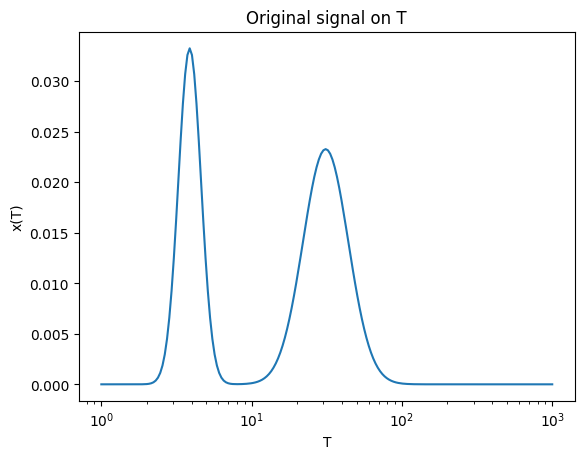

In [16]:
plt.plot(T, x_bar)
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('x(T)')
plt.title("Original signal on T")
plt.show()

4.

In [17]:
M = 50
tmin = 0
tmax = 1.5

t = tmin + np.arange(M) / (M - 1) * (tmax - tmin)

5.

In [18]:
K = np.exp(-np.outer(t, T))

6.

In [19]:
z = K @ x_bar

sigma = 0.01 * z[0]
w = np.random.normal(0, sigma, M)

y = z + w

7.

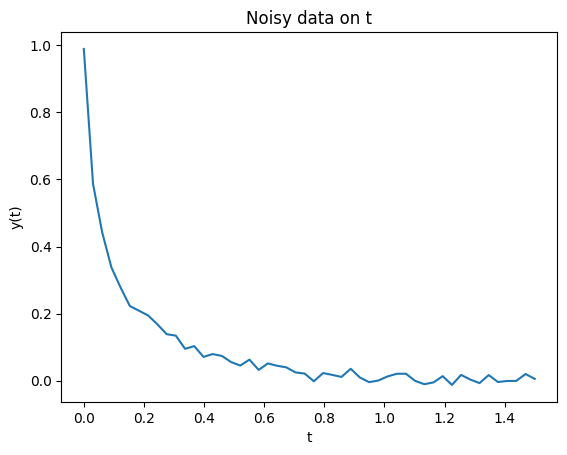

In [20]:
plt.plot(t, y)
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title("Noisy data on t")
plt.show()

# 3 - Comparison of regularization strategies

$$
\hat{x} \in \underset{x\in\mathbb{R}^N}{\arg\min} \, \frac12 \| Kx - y \|^2 + \beta g(x)
$$

## Smoothness prior

**1.**

The minimization problem is

$$
\hat{x} \in \underset{x\in\mathbb{R}^N}{\arg\min} \frac12 \| Kx - y \|^2 + \frac{\beta}{2} \| Dx \|^2
$$

The hessian of the function $h: x \mapsto \dfrac12 \| Kx - y \|^2 + \dfrac{\beta}{2} \| Dx \|^2$ is given by $\nabla^2 h(x) = K^T K + \beta D^T D$.

For $u\in\mathbb{R}^N$, we have $u^T \nabla^2 h(x) u = \| Ku \|^2 + \beta \| Du \|^2 \geq 0$.

Assume that $u^T \nabla^2 h(x) u = 0$ for some $u \neq 0$, so $Ku = 0$ and $Du = 0$. But $Du = 0$ implies that there exists $\lambda\in\mathbb{R}$ such that $u = \lambda {\bf 1}$ where ${\bf 1}$ is the vector containing only ones. $u$ being non-zero, we have $\lambda \neq 0$. And by definition, the coefficients of $K$ are strictly positive, so $Ku = \lambda K{\bf 1}$ only has non-zero coefficients, which is a contradiction (with $Ku = 0$).

So we have $\forall x \in \mathbb{R}^N, \forall u \in \mathbb{R}^N \backslash \{ 0 \}, u^T \nabla^2 h(x) u > 0$, so the hessian of $h$ is positive definite, and $h$ is strictly convex on $\mathbb{R}^N$, so it has at most one minimizer.

And the gradient of $h$ is $\nabla h(x) = (\underbrace{K^T K + \beta D^T D}_{\text{invertible}})x - K^T y$, which is zero only for $x = (K^T K + \beta D^T D)^{-1} K^T y$, so $h$ has a unique minimizer, which is given by $\hat{x} = (K^T K + \beta D^T D)^{-1} K^T y$.



**2.** From 1. we can solve problem 4. by computing $\boxed{\hat{x} = (K^T K + \beta D^T D)^{-1} K^T y}$.

Best beta: 3.1622776601683795.
Corresponding error: 0.273.


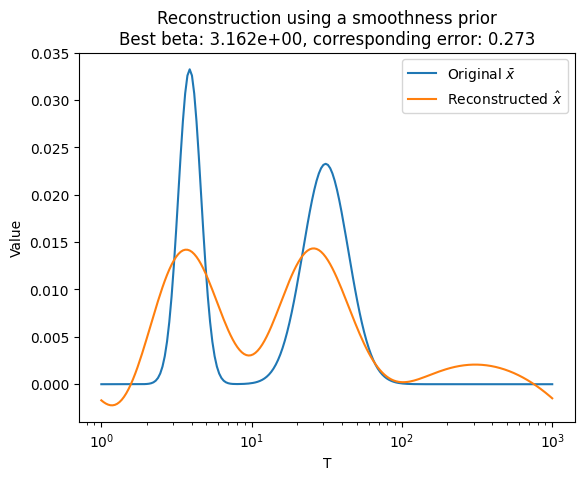

In [21]:
# 3. 4. 5.

# Construct the matrix D
D = np.eye(N)
for i in range(N):
    D[(i + 1) % N, i] = -1

# Possible values for beta
beta_list = np.logspace(-3, 1.5, 10, base = 10, endpoint = True)

# Solve for x_hat, compute the error
x_hat_array = np.linalg.inv((K.T @ K)[None, :, :] + beta_list[:, None, None] * (D.T @ D)[None, :, :]) @ (K.T @ y)
error = (np.linalg.norm(x_hat_array - x_bar[None, :], ord = 2, axis = 1) / np.linalg.norm(x_bar, ord = 2))**2

# Find the best beta
beta_best = beta_list[np.argmin(error)]
x_smoothness = x_hat_array[np.argmin(error)]
error_smoothness = np.min(error)

# Print and plot the results
print(f'Best beta: {beta_best}.')
print(f'Corresponding error: {error_smoothness:.3f}.')

plt.plot(T, x_bar, label = r'Original $\bar{x}$')
plt.plot(T, x_smoothness, label = r'Reconstructed $\hat{x}$')
plt.xlabel('T')
plt.ylabel('Value')
plt.xscale('log')
plt.legend()
plt.title(f"Reconstruction using a smoothness prior\nBest beta: {beta_best:.3e}, corresponding error: {error_smoothness:.3f}")

plt.show()

We see that $\hat{x}$ has, like $\bar{x}$, two peaks, though they are translated in $T$, and not as sharp as the original ones.

We also see that $\hat{x}$ takes negative values, which in the NMR diffusion model does not make sense.

##  Smoothness prior + constraints

**1.**

The minimzation problem is
$$
\hat{x} \in \underset{x\in\mathbb{R}^N}{\arg\min} \frac12 \| Kx - y \|^2 + \frac{\beta}{2} \| Dx \|^2 + \iota_{[x_{\min}, x_{\max}]^N}(x).
$$

This means we actually seek to minimize the function $h: x \mapsto \dfrac12 \| Kx - y \|^2 + \dfrac{\beta}{2} \| Dx \|^2$ from the previous question on the domain $[x_{\min}, x_{\max}]^N$.

Since this domain $[x_{\min}, x_{\max}]^N$ is a compact subset of $\mathbb{R}^N$, and since $h$ is continuous, the restriction of $h$ to this domain has a minimum, which is necessarily unique because we have seen that $h$ is strictly convex.

So $\hat{x}$ exists and is unique.

**2.**
We seek to minimize $h$ on $[x_{\min}, x_{\max}]^N$, so we will use the  projected gradient algorithm.

We define (again) $h: x \mapsto \frac12 \| Kx - y \|^2 + \frac{\beta}{2} \| Dx \|^2$.

$C = [x_{\min}, x_{\max}]^N$ is a nonempty closed convex subset of $\mathbb{R}^N$.

We also have $h \in \Gamma_0(\mathbb{R}^N)$ (we have seen that $h$ is convex; its domain is $\mathbb{R}^N \neq \emptyset$; $h$ is continuous thus lower semi-continuous), $h$ is differentiable, and its gradient is $\nu$-Lipschitz, where $\nu$ is the maximum eigenvalue of $\nabla^2 h(x) = K^T K + \beta D^T D$.

So we compute $\nu$ numerically, we let $\gamma \in \left]0, \dfrac{2}{\nu} \right[$, we set $\delta = 2 - \gamma \nu / 2 \in]1, 2[$, and we let $\lambda \in ]0, 1[$.

Then, we define $x_0 \in \mathbb{R}^N$, and $\forall n \in \mathbb{N}, y_n = x_n - \gamma \nabla h(x_n)$, $x_{n + 1} = x_n + \lambda \left(\text{proj}_{[x_{\min}, x_{\max}]^N} y_n - x_n \right)$, where $\text{proj}_{[x_{\min}, x_{\max}]^N}$ is the orthogonal projection on $[x_{\min}, x_{\max}]^N$, and $\nabla h(x_n) = K^T (Kx_n - y) + \beta D^T D x_n$.

Since we have seen previously that $\underset{x\in [x_{\min}, x_{\max}]^N}{\arg\min} h(x) \neq \emptyset$, we know that $(x_n)_n$ converges to $\widehat{x}$ weakly, but in finite dimension $N$ this is equivalent to strong convergence.

Here, we use $50,000$ iterations, and we vectorialize using numpy, so we do iterations for all $\beta$ values at the same time.

Best beta: 7.778e-01.
Corresponding error: 0.164.


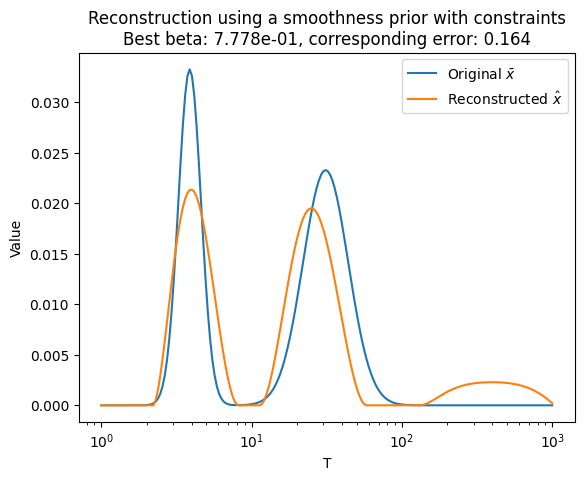

In [22]:
# 3. 4. 5.

# Define the bounds
x_min = 0
x_max = y.max()

# Construct the matrix D
D = np.eye(N)
for i in range(N):
    D[(i + 1) % N, i] = -1

# Possible values for beta
beta_list = np.linspace(1e-5, 1, 10, endpoint = True)

# Compute largest eigenvalue
eigenvalues = np.linalg.eigvalsh((K.T @ K)[None, :, :] + beta_list[:, None, None] * (D.T @ D)[None, :, :])
nu = np.max(eigenvalues, axis = 1)

gamma = 1 / nu
delta = 2 - gamma * nu / 2
lambd = 0.9

# Projected gradient descent
x = np.ones((len(beta_list), N)) * (x_min + x_max) / 2

for _ in range(50000):
    grad = ((x @ K.T - y[None, :]) @ K + beta_list[:, None] * x @ (D.T @ D))
    x_new = x + lambd * (np.clip(x - gamma[:, None] * grad, x_min, x_max) - x)
    x = np.clip(x_new, x_min, x_max)

# Compute the error
error = (np.linalg.norm(x - x_bar[None, :], ord = 2, axis = 1) / np.linalg.norm(x_bar, ord = 2))**2

# Find the best beta
beta_best = beta_list[np.argmin(error)]
x_smoothness_constraints = x[np.argmin(error)]
error_smoothness_constraints = np.min(error)

# Results
print(f'Best beta: {beta_best:.3e}.')
print(f'Corresponding error: {error_smoothness_constraints:.3f}.')

plt.plot(T, x_bar, label = r'Original $\bar{x}$')
plt.plot(T, x_smoothness_constraints, label = r'Reconstructed $\hat{x}$')
plt.xlabel('T')
plt.ylabel('Value')
plt.xscale('log')
plt.legend()
plt.title(f'Reconstruction using a smoothness prior with constraints\nBest beta: {beta_best:.3e}, corresponding error: {error_smoothness_constraints:.3f}')

plt.show()

The result is good, in the sense that once again we have two peaks (approximately at the right $T$), though once again not as sharp as the original ones. And now, we have constrained $\widehat{x}$ to take non-negative values.

## Sparsity prior

The minimization problem is
$$
\hat{x} \in \underset{x\in\mathbb{R}^N}{\arg\min} \frac12 \| Kx - y \|^2 + \beta \| x \|_1.
$$

The objective function $h: x \mapsto \dfrac12 \| Kx - y \|^2 + \beta \| x \|_1$ is continuous, convex as the sum of two convex functions, and it is coercive (because $\| \cdot \|_1$ is, and $h(x) \geq \beta \| x \|_1$), hence the existence of $\widehat{x}$.

$h$ is not differentiable everywhere, but for each $x$, we have the subdifferential
$\partial h(x) = \left\{ K^T(Kx - y) + \beta z \mid \forall i, z_i = \text{sign}(x_i) \right\}$, with the convention that $\text{sign}(0)$ is any number in $[-1, 1]$.

So $x$ minimizes $h$ if and only if $0 \in \partial h(x)$, which is equivalent to the existence of $z$ such that $K^T K x = K^T y - \beta z$ and $\forall i, z_i = \text{sign}(x_i)$

If $x$ only has non-zero coefficients, then $x$ minimizes $h$ if and only if $K^T K x = K^T y - \beta \text{sign}(x)$.

Moreover, $\ker(K^T K) = \ker(K)$, and $K$ is an $M \times N$ matrix with $N > M$, so $\ker(K) \neq \{ 0 \}$. Therefore $\ker(K^T K) \neq \{ 0 \}$, and $K^T K$ is singular.

As a consequence, the equation $K^T K x = K^T y - \beta \text{sign}(x)$ may have several solutions, in which case (if two of these solutions only have non-zero entries) $h$ has two minimizers. So $\hat{x}$ is not necessarily unique.

**2.**
The objective function is $h = f + g$, where:

- $g: x \mapsto \beta \| x \|_1$ is in $\Gamma_0(\mathbb{R}^N)$. Moreover, $\text{prox}_{\gamma g}(x)_i = \text{sign}(x_i) \max(|x_i| - \gamma\beta, 0)$.

- $f: x \mapsto \dfrac12 \| Kx - y \|^2$ is differentiable, with a gradient $\nu$-Lipschitz with $\nu$ the maximum eigenvalue of $\nabla^2 f = K^T K$.

So we can apply the Forward-Backward algorithm.

We let $\gamma \in ] 0, 2/\nu [$, $\delta = 2 - \gamma\nu/2$, $\lambda \in ]0, \delta[$, $x_0 \in \mathbb{R}^N$, and
$$
\begin{cases}
    y_n &= x_n - \gamma\nabla f(x_n) &= x_n - \gamma K^T(Kx - y) \\
    x_{n + 1} &= x_n + \lambda (\text{prox}_{\gamma g}(y_n) - x_n) &= x_n + \lambda(\text{sign}(y_n) \max(|y_n| - \gamma\beta, 0) - x_n)
\end{cases}
$$

Best beta: 0.00129.
Corresponding error: 0.183.


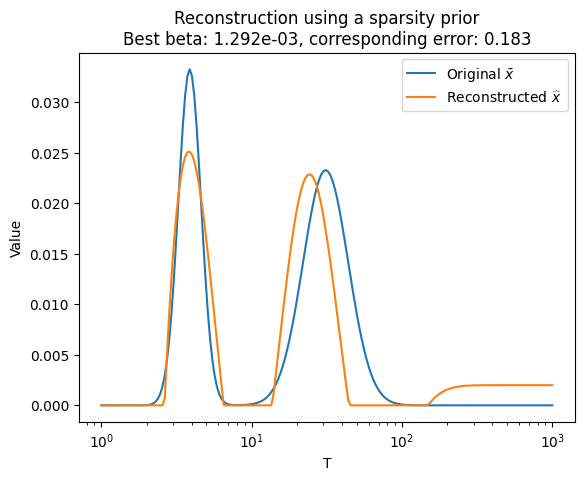

In [23]:
# 3. 4. 5.

# Possible values for beta
beta_list = np.logspace(-6, 1, 10, base = 10, endpoint = True)

# Compute largest eigenvalue
eigenvalues = np.linalg.eigvalsh(K.T @ K)
nu = eigenvalues.max()

gamma = 1 / nu
delta = 2 - gamma * nu / 2
lambd = 0.9
assert 0 < lambd < delta

# Forward-backward algorithm
x = np.ones((len(beta_list), N)) * (x_min + x_max) / 2

for _ in range(50000):
    grad = (x @ K.T - y[None, :]) @ K
    y_n = x - gamma * grad
    prox = np.sign(y_n) * np.maximum(np.abs(y_n) - gamma * beta_list[:, None], 0)
    x_new = x + lambd * (prox - x)
    x = x_new

# Compute the error
error = (np.linalg.norm(x - x_bar[None, :], ord = 2, axis = 1) / np.linalg.norm(x_bar, ord = 2))**2

# Find the best beta
beta_best = beta_list[np.argmin(error)]
x_sparsity = x[np.argmin(error)]
error_sparsity = np.min(error)

# Results
print(f'Best beta: {beta_best:.5f}.')
print(f'Corresponding error: {error_sparsity:.3f}.')

plt.plot(T, x_bar, label = r'Original $\bar{x}$')
plt.plot(T, x_sparsity, label = r'Reconstructed $\widehat{x}$')
plt.xlabel('T')
plt.ylabel('Value')
plt.xscale('log')
plt.legend()
plt.title(f'Reconstruction using a sparsity prior\nBest beta: {beta_best:.3e}, corresponding error: {error_sparsity:.3f}')

plt.show()

We once again recover two peaks. Even though we did not constraint $\hat x$ to be non-negative, it (almost) is.

The error is lower than with the previous priors.

# Part II

## 1. Maximum entropy regularization

$$\hat{x} = \underset{x \in \mathbb{R}^N}{\arg\min} \, \frac12 \|Kx - y\|^2 + \beta \, \text{ent}(x)$$

where $\forall x \in \mathbb{R}^N, \text{ent}(x) = \sum\limits_{n = 1}^N \varphi(x^{(n)})$, with
$$
\varphi(u) =
\begin{cases}
    u \log u & \text{if $u > 0$} \\
    0 & \text{if $u = 0$} \\
    +\infty & \text{elsewhere.}
\end{cases}
$$

**1.**

- $\text{ent}$ is (strictly) convex.

Indeed, we have $\text{ent} = \sum\limits_{n = 1}^N \varphi \circ \text{proj}_n$ where $\text{proj}_n: x \mapsto x^{(n)}$ is linear.

Note that $\forall u > 0, \varphi'(u) = 1 + \log(u)$ which is strictly increasing on $\text{dom}(\varphi) = \mathbb{R}_{++}$, so $\varphi$ is (strictly) convex.

Therefore each $\varphi \circ \text{proj}_n$ is convex (composition of a convex function with an affine one), and $\text{ent}$ is convex as a sum of convex functions.

- $\text{ent}$ is proper.

Indeed, $\text{ent}$ is a function valued in $]-\infty, +\infty]$ with domain $\mathbb{R}_+^N$.

- $\text{ent}$ is lower-semicontinuous.

This comes from the fact that $\varphi$ is l.s.c., because its epigraph $\{ (x, y) \mid x > 0, y \geq x \log x \}\cup\{(0, y) \mid y \leq 0\}$ is closed.

Therefore each $\varphi \circ \text{proj}_n$ is lower semi-continuous: take $(x_k)$ a sequence that converges to $x$, then for each $n \in [\![ 1, N ]\!], x_k^{(n)} \underset{k\to+\infty}{\longrightarrow} x^{(n)}$, and $\varphi$ is l.s.c. so $\underset{k\to+\infty}{\lim\inf} \varphi(x_k^{(n)}) \geq \varphi(x^{(n)})$, i.e. $\underset{k\to+\infty}{\lim\inf} (\varphi \circ \text{proj}_n)(x_k) \geq (\varphi \circ \text{proj}_n)(x)$.

So $\text{ens}$ is l.s.c. as a sum of l.s.c. functions.

- $\text{ent}$ is differentiable on $\mathbb{R}_{++}^N$ as a sum of functions which are differentiable (because $\varphi$ is differentiable on $\mathbb{R}_{++}$ and projections are differentiable).

**2.**

Since $\text{dom}(\text{ent}) = \mathbb{R}_+^N$, minimizing $h: x \mapsto \frac12 \| Kx - y \|^2 + \beta \text{ent}(x)$ on $\mathbb{R}^N$ is equivalent to minimizing it on $\mathbb{R}_+^N$.

Now, $h(x) \geq \beta \text{ent}(x) \underset{x\in\mathbb{R}_+^N, \| x \| \to +\infty}{\longrightarrow} +\infty$: $h$ is coercive on $\mathbb{R}_+^N$, and continuous, so it has a minimizer.

And $h$ is the sum of two convex functions, one of which is strictly convex, so $h$ is strictly convex. Therefore its minimizer is unique.

**3.** The Lambert function $W$ satisfies $\forall x, W(x) \exp(W(x)) = x$.

$\text{ent} \in \Gamma_0(\mathbb{R}^N)$ by question 1., so its proximity operator is well defined.

Let $\gamma > 0$ and $x \in \mathbb{R}^N$.

$\text{prox}_{\gamma\text{ent}}(x)
= \underset{y}{\arg\min} \, \left( \gamma\text{ent}(y) + \dfrac12 \| y - x \|^2 \right)
= \underset{y}{\arg\min} \, \sum\limits_{n = 1}^N \left( \gamma \varphi(y^{(n)}) + \dfrac12 (y^{(n)} - x^{(n)})^2 \right)$.

So $y = \text{prox}_{\gamma\text{ent}}(x)$ if and only if, for each $n = 1, \dots, N$, $y^{(n)} = \text{prox}_{\gamma\varphi}(x^{(n)})$.

And for $x\in\mathbb{R}$, the derivative of $y \mapsto \gamma \varphi(y) + \dfrac12 (y - x)^2$ is
$y \mapsto \gamma + \gamma\log(y) + y - x = \gamma \left( \log\left(\frac{y}{\gamma} e^{y / \gamma}\right) + 1 + \log\gamma - \frac{x}{\gamma} \right)$, which is zero for $\frac{y}{\gamma} e^{y/\gamma} = \exp\left(\frac{x}{\gamma} - 1 - \log\gamma \right)$, that is $y/\gamma = W\left( \exp\left(\frac{x}{\gamma} - 1 - \log\gamma \right) \right)$.

So $\text{prox}_{\gamma\text{ent}}(x) = \gamma \left( W\left( \exp\left( \dfrac{x^{(1)}}{\gamma} - 1 - \log\gamma\right)\right), \dots, W\left( \exp\left( \dfrac{x^{(N)}}{\gamma} - 1 - \log\gamma\right)\right) \right)$, which can be rewritten
$$\boxed{\text{prox}_{\gamma\text{ent}}(x) = \gamma W\left( \exp\left( \dfrac{x}{\gamma} - 1 - \log\gamma\right)\right)}$$
where $W$ is applied component-wise.

**4.**

We set $f(x) = \beta \text{ent}(x)$, $g(x) = \dfrac12 \| Kx - y \|^2$, and $h = f + g$.

- We have seen in question 1. that $f \in \Gamma_0(\mathbb{R}^N)$. And $g \in \Gamma_0(\mathbb{R}^N)$ is differentiable with a $\nu$-Lipschitz gradient where $\nu$ is the largest eigenvalue of $K^T K$.

We can then use the Forward-Backward algorithm,
$$
\begin{cases}
    y_n = x_n - \gamma K^T (K x_n - y) \\
    x_{n + 1} = x_n + \lambda_n \left(\gamma \beta W \left( \exp\left( \dfrac{y_n}{\gamma \beta} - 1 - \log(\gamma \beta) \right) \right) - x_n \right),
\end{cases}
$$
where $\gamma \in ]0, 2 / \nu [$, $\delta = 2 - \gamma\nu / 2$, $\lambda_n \in [0, \delta]$ such that $\sum\limits_n \lambda_n (\delta - \lambda_n) = +\infty$.

- We can also use Douglas-Rachford algorithm because $f$ and $g$ both belong to $\Gamma_0(\mathbb{R}^N)$.

We compute $\text{prox}_{\gamma g}(x) = \underset{z}{\arg\min} \, \gamma \| Kz - y \|^2 / 2 + \frac12 \| z - x \|^2$. We set the gradient of this last quantity equal to $0$: $\gamma K^T (Kz - y) + (z - x) = 0$ so $(\gamma K^T K + I) z = x + \gamma K^T y$, and therefore $\text{prox}_{\gamma g}(x) = (\gamma K^T K + I)^{-1}(x + \gamma K^T y)$.

We then set $\gamma > 0$, $\lambda_n \in [0, 2]$ such that $\sum\limits_n \lambda_n (2 - \lambda_n) = +\infty$, and:
$$
\begin{cases}
    y_n = (\gamma K^T K + I)^{-1}(x_n + \gamma K^T y) \\
    z_n = \gamma\beta W\left( \exp\left( \dfrac{2y_n - x_n}{\gamma\beta} - 1 - \log(\gamma\beta)\right)\right) \\
    x_{n + 1} = x_n + \lambda_n (z_n - y_n)
\end{cases}.
$$


**5.** We need to compute $W(\exp(a))$, i.e. to solve $xe^x = e^a$.

We use the function `lambertw` from the `scipy.special` package. We slightly modify it to avoid numerical errors, by writting a function `lambert_w_of_exp(a)` which computes $W(e^a)$.

In [24]:
from scipy.special import lambertw

def lambert_w_of_exp(a):
    if a < -700:
        return 0
    if a > 100:
        return a - np.log(a)
    else:
        return lambertw(np.exp(a)).real

lambert_w_of_exp = np.vectorize(lambert_w_of_exp)

Error between original and reconstruction for beta = 1.000e-02: 0.582


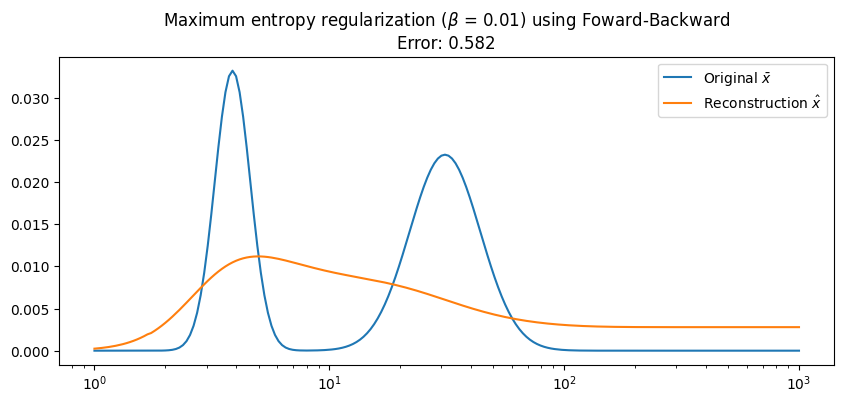

In [25]:
# Forward-backward algorithm

def forward_backward(y, K, beta):
    N = K.shape[1]
    nu = np.sort(np.linalg.eigvalsh(K.T.dot(K)))[-1]
    gamma = 1. / nu
    lambd = 1.

    x_n = np.ones(N) * (y.max() + y.min()) / 2
    for _ in range(50000):
        y_n = x_n - gamma * K.T.dot(K @ x_n - y)
        x_n = x_n + lambd * (gamma * beta * lambert_w_of_exp(y_n / (gamma * beta) - 1 - np.log(gamma * beta)) - x_n)

    return x_n

beta = 1e-2
x_hat = forward_backward(y, K, beta)

error = (np.linalg.norm(x_hat - x_bar) / np.linalg.norm(x_bar))**2

print(f"Error between original and reconstruction for beta = {beta:.3e}: {error:.3f}")

plt.figure(figsize = (10, 4))
plt.title(rf"Maximum entropy regularization ($\beta$ = {beta}) using Foward-Backward" + "\n" + rf"Error: {error:.3f}")
plt.plot(T, x_bar, label = r"Original $\bar{x}$")
plt.plot(T, x_hat, label = r"Reconstruction $\hat{x}$")
plt.xscale("log")
plt.legend()
plt.show()

Error between original and reconstruction for beta = 1.000e-02: 0.583


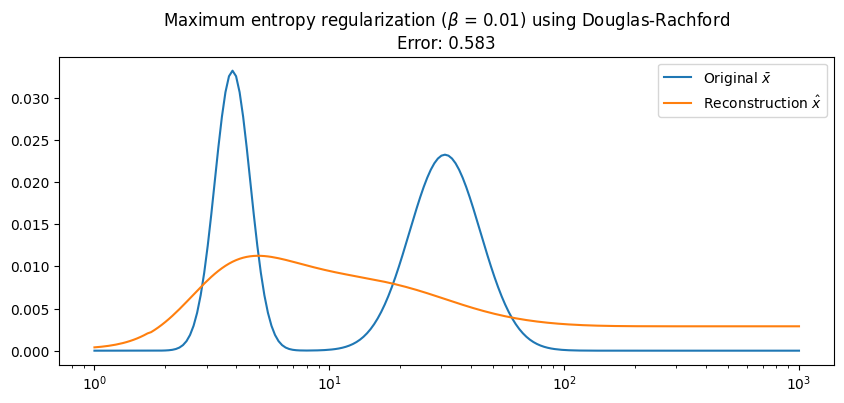

In [26]:
# Douglas-Rachford

def douglas_rachford(y, K, beta):
    N = K.shape[1]

    nu = np.sort(np.linalg.eigvalsh(K.T @ K))[-1]
    gamma = 1. / nu
    lambd = 1.

    mat_inv = np.linalg.inv(gamma * K.T @ K + np.eye(N))

    x_n = np.ones(N) * (y.max() + y.min()) / 2
    for _ in range(50000):
        y_n = mat_inv @ (x_n + gamma * K.T @ y)
        z_n = gamma * beta * lambert_w_of_exp((2 * y_n - x_n) / (gamma * beta) - 1 - np.log(gamma * beta)).real
        x_n = x_n + lambd * (z_n - y_n)

    return x_n

x_hat = douglas_rachford(y, K, beta)

error = (np.linalg.norm(x_hat - x_bar) / np.linalg.norm(x_bar))**2

print(f"Error between original and reconstruction for beta = {beta:.3e}: {error:.3f}")

plt.figure(figsize = (10, 4))
plt.title(rf"Maximum entropy regularization ($\beta$ = {beta}) using Douglas-Rachford" + "\n" + rf"Error: {error:.3f}")
plt.plot(T, x_bar, label = r"Original $\bar{x}$")
plt.plot(T, x_hat, label = r"Reconstruction $\hat{x}$")
plt.xscale("log")
plt.legend()
plt.show()

The results are not really good; we will improve them by tuning the value of $\beta$ in the next question.

**6.** We test several values of $\beta$ for the Forward-Backward algorithm.

Best beta: 1.000e-08
Error: 0.197


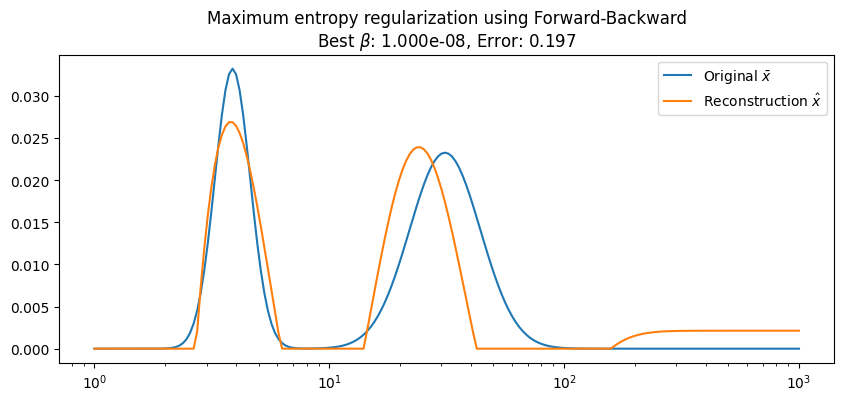

In [27]:
# Forward-backward

num_values_beta = 3 # Can be changed to get a better approximation, but it takes more time
beta_range = np.logspace(-12, -8, num_values_beta, endpoint = True)

error_FB = np.inf
best_beta = None
x_FB = None

for beta in beta_range:
    x_hat = forward_backward(y, K, beta)
    error = (np.linalg.norm(x_hat - x_bar) / np.linalg.norm(x_bar))**2

    if error < error_FB:
        error_FB = error
        best_beta = beta
        x_FB = x_hat

print(f"Best beta: {best_beta:.3e}")
print(f"Error: {error_FB:.3f}")

plt.figure(figsize = (10, 4))
plt.title(rf"Maximum entropy regularization using Forward-Backward" + "\n" + rf"Best $\beta$: {best_beta:.3e}, Error: {error_FB:.3f}")
plt.plot(T, x_bar, label = r"Original $\bar{x}$")
plt.plot(T, x_FB, label = r"Reconstruction $\hat{x}$")
plt.xscale("log")
plt.legend()
plt.show()

We do the same thing for Douglas-Rachford algorithm.

Best beta: 1.000e-06
Error: 0.196


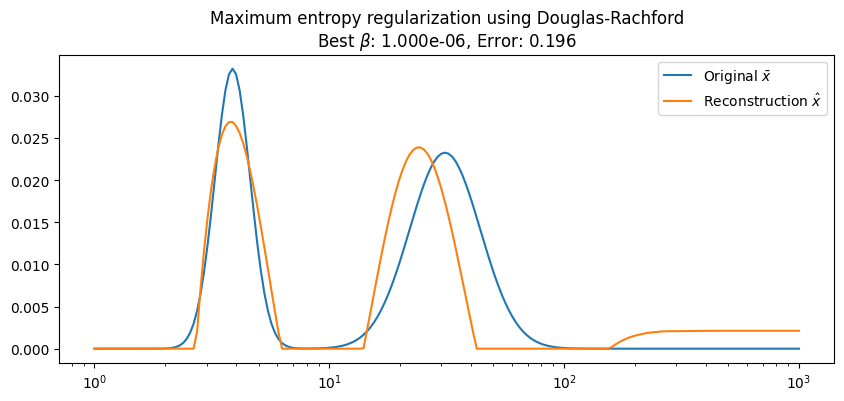

In [28]:
# Douglas-Rachford

num_values_beta = 3 # Can be changed to get a better approximation, but it takes more time
beta_range = np.logspace(-8, -6, num_values_beta, endpoint = True)

error_DR = np.inf
best_beta = None
x_DR = None

for beta in beta_range:
    x_hat = douglas_rachford(y, K, beta)
    error = (np.linalg.norm(x_hat - x_bar) / np.linalg.norm(x_bar))**2

    if error < error_DR:
        error_DR = error
        best_beta = beta
        x_DR = x_hat

print(f"Best beta: {best_beta:.3e}")
print(f"Error: {error_DR:.3f}")

plt.figure(figsize = (10, 4))
plt.title(rf"Maximum entropy regularization using Douglas-Rachford" + "\n" + rf"Best $\beta$: {best_beta:.3e}, Error: {error_DR:.3f}")
plt.plot(T, x_bar, label = r"Original $\bar{x}$")
plt.plot(T, x_DR, label = r"Reconstruction $\hat{x}$")
plt.xscale("log")
plt.legend()
plt.show()

We see for Forward-Backward and Douglas-Rachford that low values of $\beta$ are required to have a low reconstruction error.

**7.**

In [29]:
from IPython.display import display, Markdown

table = f"""
$$
\\begin{{array}}{{|l|c|}}
\\hline
\\textbf{{Algorithm}} & \\textbf{{Normalized Quadratic Error}} \\\\
\\hline
\\text{{Smoothness prior}} & {error_smoothness:.4f} \\\\
\\text{{Smoothness prior + constraints}} & {error_smoothness_constraints:.4f} \\\\
\\text{{Sparsity prior}} & {error_sparsity:.4f} \\\\
\\text{{Forward Backward}} & {error_FB:.4f} \\\\
\\text{{Douglas Rachford}} & {error_DR:.4f} \\\\
\\hline
\\end{{array}}
$$
"""

display(Markdown(table))



$$
\begin{array}{|l|c|}
\hline
\textbf{Algorithm} & \textbf{Normalized Quadratic Error} \\
\hline
\text{Smoothness prior} & 0.2725 \\
\text{Smoothness prior + constraints} & 0.1639 \\
\text{Sparsity prior} & 0.1831 \\
\text{Forward Backward} & 0.1967 \\
\text{Douglas Rachford} & 0.1962 \\
\hline
\end{array}
$$


The results can change a lot from one execution to another. In the results above, the smoothness prior + constraints performed much better than the others.

This may come partly from the $\beta$ parameter: due to the rather long time required to run the algorithms, we only try a few values of $\beta$, and may therefore not find the optimal one. Using more values for `beta` is simple, simply by changing the value of the variable `num_values_beta`.

**8.**

$$
\underset{x \in \mathbb{R}^N}{\text{minimize}} \ \text{ent}(x) \, \text{s.t.} \, \| Kx - y \|^2 \leq \eta M \sigma^2
$$

can be rewritten

$$
\underset{x \in \mathbb{R}^N}{\text{minimize}} \ \text{ent}(x) + \iota_{B(y, \sigma \sqrt{\eta M})}(Kx),
$$
with $B(y, \sigma \sqrt{\eta M})$ the closed ball with center $y$ and radius $\sigma \sqrt{\eta M}$.

Then, using the same notations as in the lectures, we can set $\mathcal{H}_1 = \mathbb{R}^N$, $\mathcal{H}_2 = \text{ran}(K)$, $\mathcal{H} = \mathcal{H}_1 \times \mathcal{H}_2$.

We also set $g_1: x \in \mathcal{H}_1 \mapsto \text{ent}(x)$, $g_2: x \in \mathcal{H}_2 \mapsto \iota_{B(y, \sigma \sqrt{\eta M})}(x)$, which satisfy $g_i \in \Gamma_0(\mathcal{H}_i)$ for $i = 1, 2$.

Let $L_1 = I_N$, $L_2 = K$ which are bounded operators.

Then we want to minimize $g_1 \circ L_1 + g_2 \circ L_2$.

We can use the PPXA+ algorithm.

We have, for $\gamma > 0$:

$\text{prox}_{\gamma g_1}(x) = \gamma W\left( \exp\left( \dfrac{x}{\gamma} - 1 - \log\gamma \right)\right)$
and
$\text{prox}_{\gamma g_2}(x) = y + (x - y) \min\left( 1, \dfrac{\sigma\sqrt{\eta M}}{\| x - y \|} \right)$.

Then the algorithm is:

$$
\begin{cases}
    y_{n, 1} = \gamma W\left( \exp\left( \dfrac{x_{n, 1}}{\gamma} - 1 - \log\gamma \right)\right) \\
    y_{n, 2} = y + (x_{n, 2} - y) \min\left( 1, \dfrac{\sigma\sqrt{\eta M}}{\| x_{n, 2} - y \|} \right) \\
    c_n = \left( I_n + K^T K \right)^{-1} \left( y_{n, 1} + K^T y_{n, 2} \right) \\
    x_{n + 1, 1} = x_{n, 1} + \lambda_n \left( 2 c_n - v_n - y_{n, 1} \right) \\
    x_{n + 1, 2} = x_{n, 2} + \lambda_n \left( K(2 c_n - v_n) - y_{n, 2} \right) \\
    v_{n + 1} = v_n + \lambda_n (c_n - v_n)
\end{cases},
$$

with $\gamma > 0$, $\lambda_n\in[0, 2]$ such that $\sum\limits_n \lambda_n (2 - \lambda_n) = +\infty$, $v_0 = \left( I_n + K^T K \right)^{-1} (x_{0, 1} + K^T x_{0, 2})$.

In [30]:
# PPXA+

def PPXA(y, K, eta, gamma, lambd):
    N = K.shape[1]
    M = K.shape[0]
    mat_inv = np.linalg.inv(K.T @ K + np.eye(N))

    x_n1 = np.ones(N) * (y.max() + y.min()) / 2
    x_n2 = np.ones(M) * (y.max() + y.min()) / 2

    v_n = mat_inv @ (x_n1 + K.T @ x_n2)

    for _ in range(50000):
        y_n1 = gamma * lambert_w_of_exp(x_n1 / gamma - 1 - np.log(gamma))
        y_n2 = y + (x_n2 - y) * min(1, sigma * np.sqrt(eta * M) / np.linalg.norm(x_n2 - y))

        c_n = mat_inv @ (y_n1 + K.T @ y_n2)

        x_n1 = x_n1 + lambd * (2 * c_n - v_n - y_n1)
        x_n2 = x_n2 + lambd * (K @ (2 * c_n - v_n) - y_n2)

        v_n = v_n + lambd * (c_n - v_n)
    
    return v_n

Error between original and reconstruction: 0.192


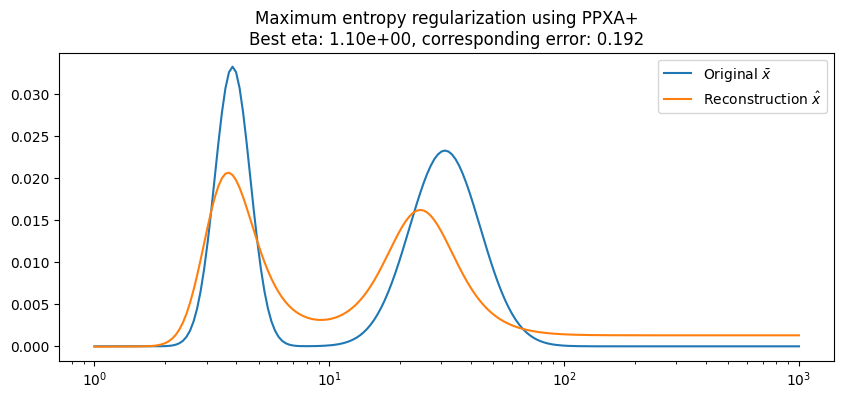

In [31]:
error_PPXA = np.inf
x_PPXA = None
best_eta = None

gamma = 0.5
lambd = 1.

for eta in [0.5, 0.7, 0.9, 1.1]:
    x_hat = PPXA(y, K, eta, gamma, lambd)
    error = (np.linalg.norm(x_hat - x_bar) / np.linalg.norm(x_bar))**2

    if error < error_PPXA:
        error_PPXA = error
        x_PPXA = x_hat
        best_eta = eta

print(f"Error between original and reconstruction: {error_PPXA:.3f}")

plt.figure(figsize = (10, 4))
plt.title(rf"Maximum entropy regularization using PPXA+" + "\n" + rf"Best eta: {best_eta:.2e}, corresponding error: {error_PPXA:.3f}")
plt.plot(T, x_bar, label = r"Original $\bar{x}$")
plt.plot(T, x_PPXA, label = r"Reconstruction $\hat{x}$")
plt.xscale("log")
plt.legend()
plt.show()

In [32]:
from IPython.display import display, Markdown

table = f"""
$$
\\begin{{array}}{{|l|c|}}
\\hline
\\textbf{{Algorithm}} & \\textbf{{Normalized Quadratic Error}} \\\\
\\hline
\\text{{Smoothness prior}} & {error_smoothness:.4f} \\\\
\\text{{Smoothness prior + constraints}} & {error_smoothness_constraints:.4f} \\\\
\\text{{Sparsity prior}} & {error_sparsity:.4f} \\\\
\\text{{Forward Backward}} & {error_FB:.4f} \\\\
\\text{{Douglas Rachford}} & {error_DR:.4f} \\\\
\\text{{PPXA+}} & {error_PPXA:.4f} \\\\
\\hline
\\end{{array}}
$$
"""

display(Markdown(table))



$$
\begin{array}{|l|c|}
\hline
\textbf{Algorithm} & \textbf{Normalized Quadratic Error} \\
\hline
\text{Smoothness prior} & 0.2725 \\
\text{Smoothness prior + constraints} & 0.1639 \\
\text{Sparsity prior} & 0.1831 \\
\text{Forward Backward} & 0.1967 \\
\text{Douglas Rachford} & 0.1962 \\
\text{PPXA+} & 0.1916 \\
\hline
\end{array}
$$


For this execution, PPXA got the best results. Note however, once again, that this can totally change from one execution to another.

Because the results can vary a lot from one execution to another, we computed the results for $200$ different examples of $y$, with $w \sim N(0, 1)$ . Here are the results:

In [35]:
# Load the errors data
data = pd.read_csv("error.csv")

# Compute the mean and standard error for each column
summary = data.agg(['mean', lambda x: x.std() / np.sqrt(len(x))]).T
summary.columns = ['Mean', 'Standard Error']

# Count the number of times each algorithm is the argmin
argmin_counts = data.idxmin(axis=1).value_counts()*100 / len(data)

# Add the counts to the summary dataframe
summary['Argmin Percentage'] = summary.index.map(argmin_counts).fillna(0).astype(int)

table = """
| Algotithm | Mean | Standard Error | Argmin Percentage |
|-----------|------|----------------|-------------------|
"""

for index, row in summary.iterrows():
    table += f"| {index} | {row['Mean']:.4f} | {row['Standard Error']:.4f} | {row['Argmin Percentage']:.0f} |\n"

display(Markdown(table))


| Algotithm | Mean | Standard Error | Argmin Percentage |
|-----------|------|----------------|-------------------|
| Smoothness prior | 0.3447 | 0.0087 | 0 |
| Smoothness prior + constraints  | 0.1213 | 0.0064 | 43 |
| Sparsity Prior | 0.1356 | 0.0069 | 22 |
| Forward Backward | 0.4623 | 0.0237 | 0 |
| Douglas Rachford | 0.4611 | 0.0236 | 0 |
| PPXA+ | 0.1361 | 0.0068 | 34 |


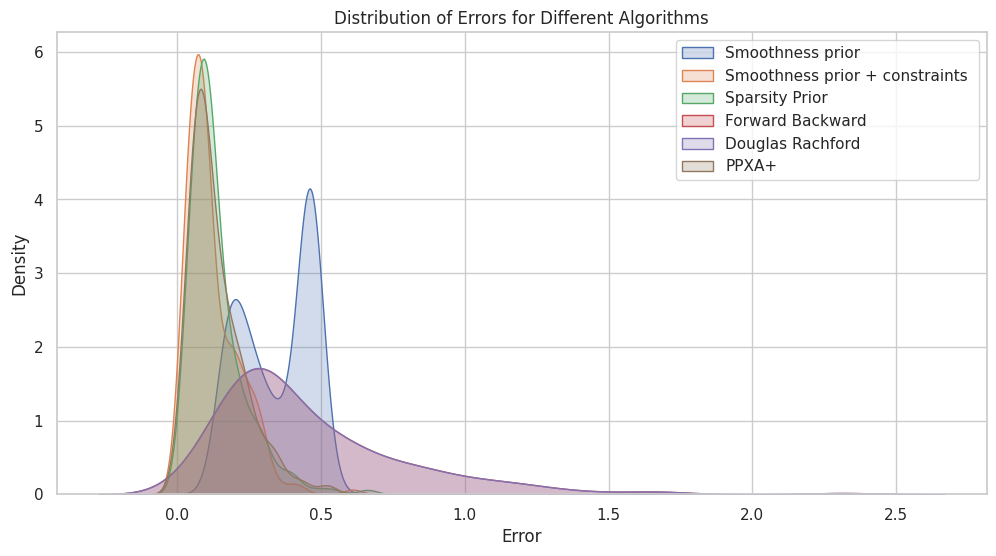

In [34]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot the distribution of each column
for column in data.columns:
    sns.kdeplot(data[column], label=column, fill=True)

# Add labels and title
plt.xlabel('Error')
plt.ylabel('Density')
plt.title('Distribution of Errors for Different Algorithms')
plt.legend()

# Show the plot
plt.show()

We can see with this figure that the best algorithm seems to be Smoothness prior + constraints, even though the results are close to the ones of both Sparsity prior and PPXA+. Forward-Backward and Douglas-Rachford are not very good, and the results are pretty similar for both of them.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2a4063b7-21c7-4933-a296-f291ec05cc4f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>